In [1]:
# Pan card fraud detection- DataFlair
import os
import cv2
import time
import random
import numpy as np
from tqdm import tqdm
import Augmenter as ag
import tensorflow as tf
import matplotlib.pyplot as plt              
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout

In [2]:
augmentation_limit = 15
def augment_image(image):
    """Performs image augmentation operations"""
    choice_X = random.randint(-augmentation_limit, augmentation_limit)
    choice_Y = random.randint(-augmentation_limit, augmentation_limit)
    
    return ag.shift_image(image, choice_X, choice_Y)

In [3]:
img_size = 48
number_of_augmentation = 23
datadir = r'images'    # root data directiory
CATEGORIES = os.listdir(datadir)
print(CATEGORIES)

['7', '3', '6', '1', '0', '4', '8', '2', '5', '9']


In [4]:
l = np.arange(0, 10)

In [5]:
l = [str(i) for i in l]
l

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [6]:
# Preprocessing Function
def PreProcess(img_size, path):
    """This function reads images from the given folders subfolder 
        and returns a normalized array along with their respective classes"""
    x, y = [], []
    CATEGORIES = np.arange(0, 10)
    CATEGORIES = [str(i) for i in CATEGORIES]
    print("Found {} classes: {}".format(len(CATEGORIES), CATEGORIES))
    
    for category in CATEGORIES:
        path = os.path.join(datadir, str(category))
        classIndex = CATEGORIES.index(category)
        
        # Reads each image from the directory
        for imgs in tqdm(os.listdir(path)):
            img_arr = cv2.imread(os.path.join(path, imgs), 0)
#             _, img_arr = cv2.threshold(img_arr, 70, 255, cv2.THRESH_BINARY_INV)
            # resize the image
            resized_array = cv2.resize(img_arr, (img_size, img_size))
            cv2.imshow("images", resized_array)
            cv2.waitKey(1)

            # Augmentation
            for i in range(number_of_augmentation):
                augmented_array = augment_image(resized_array)
                normalized_array = augmented_array/255.0 # Normalize the array
                x.append(normalized_array)
                y.append(classIndex)
    cv2.destroyAllWindows()
    return x, y, CATEGORIES

x, y, CATEGORIES = PreProcess(img_size, datadir)


Found 10 classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


 23%|██▎       | 233/1035 [00:03<00:12, 65.69it/s]


KeyboardInterrupt: 

In [7]:
# Split the dataset into training and testing
X_train, x_test, Y_train, y_test = train_test_split(x, y, random_state=42)
x = None
y = None
# Convert all the list to numpy array
X_train = np.array(X_train).reshape(-1, img_size, img_size, 1)
x_test = np.array(x_test).reshape(-1, img_size, img_size, 1)
Y_train = np.array(Y_train)
y_test = np.array(y_test)

In [8]:
X_train = X_train

In [9]:
X_train.shape

(178692, 48, 48, 1)

In [10]:
# Build the model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(img_size, img_size, 1), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), strides=2, activation="relu"))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(Dropout(0.1))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), strides=2, activation="relu"))
model.add(Conv2D(16, (3, 3), activation="relu"))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(len(CATEGORIES), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 128)       73856     
_________________________________________________________________
dropout (Dropout)            (None, 19, 19, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 17, 128)       147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          7

In [11]:
def track_time(start, end):
    total = end-start
    mins, sec = 0, 0
    if total >= 60:
        mins = int(total/60)
        sec = int(total-(mins*60))
    else:
        sec = int(total)
    print ("Training took {} mins and {} seconds!".format(mins, sec))

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-OCR.h5', verbose=1, save_best_only=True)
]


In [12]:
start = time.time()
history = model.fit(X_train, Y_train, batch_size = 1024, epochs=100, validation_split=0.1, callbacks=callbacks, verbose=1)
end = time.time()
track_time(start, end)

Epoch 1/100
158/158 [==============================] - 128s 534ms/step - loss: 1.7279 - accuracy: 0.3576 - val_loss: 0.6102 - val_accuracy: 0.7962

Epoch 00001: val_loss improved from inf to 0.61021, saving model to model-OCR.h5
Epoch 2/100
158/158 [==============================] - 82s 517ms/step - loss: 0.4896 - accuracy: 0.8351 - val_loss: 0.1614 - val_accuracy: 0.9506

Epoch 00002: val_loss improved from 0.61021 to 0.16140, saving model to model-OCR.h5
Epoch 3/100
158/158 [==============================] - 82s 519ms/step - loss: 0.2149 - accuracy: 0.9312 - val_loss: 0.0866 - val_accuracy: 0.9731

Epoch 00003: val_loss improved from 0.16140 to 0.08660, saving model to model-OCR.h5
Epoch 4/100
158/158 [==============================] - 82s 522ms/step - loss: 0.1371 - accuracy: 0.9560 - val_loss: 0.0601 - val_accuracy: 0.9800

Epoch 00004: val_loss improved from 0.08660 to 0.06014, saving model to model-OCR.h5
Epoch 5/100
158/158 [==============================] - 83s 523ms/step - los


Epoch 00036: val_loss improved from 0.00206 to 0.00206, saving model to model-OCR.h5
Epoch 37/100
158/158 [==============================] - 85s 536ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.0021 - val_accuracy: 0.9995

Epoch 00037: val_loss improved from 0.00206 to 0.00205, saving model to model-OCR.h5
Epoch 38/100
158/158 [==============================] - 85s 536ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.0021 - val_accuracy: 0.9995

Epoch 00038: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00038: val_loss did not improve from 0.00205
Epoch 39/100
158/158 [==============================] - 84s 533ms/step - loss: 0.0055 - accuracy: 0.9982 - val_loss: 0.0021 - val_accuracy: 0.9995

Epoch 00039: val_loss did not improve from 0.00205
Epoch 40/100
158/158 [==============================] - 84s 529ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.0021 - val_accuracy: 0.9995

Epoch 00040: val_loss did not improve from 0.00205
Ep

In [13]:
accuracy = history.history['accuracy']
loss = history.history['loss']

Text(0.5, 1.0, 'Loss')

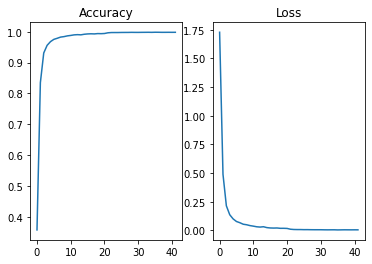

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(accuracy)
ax1.set_title("Accuracy")
ax2.plot(loss)
ax2.set_title('Loss')

In [15]:
model.evaluate(x_test, y_test)

1862/1862 [==============================] - 11s 6ms/step - loss: 0.0026 - accuracy: 0.9991


[0.0026011476293206215, 0.9991270303726196]

In [34]:
# Export the model
model.save("model2.h5")